In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13886422855578111262, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 12670240300683629112
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 4984574279401572357
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 6461660708142331760
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 12323387899099020150
 physical_dev

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


In [5]:
import os
import numpy as np
np.random.seed(777)

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [6]:
output_classes = 2
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 103104
nb_validation_samples = 12288
nb_test_samples = 697

In [7]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 103104 images belonging to 2 classes.
Found 12288 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [27]:
base_model = VGG19(weights='imagenet', include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [28]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
adam_opt=Adam(lr=1e-05, beta_1=0.6, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=True)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

with open('models/vgg19_history.txt','w') as f:
    f.write(str(history.history))

Epoch 1/50
1611/1611 [==============================] - 1229s 763ms/step - loss: 0.4352 - acc: 0.8978 - val_loss: 0.3806 - val_acc: 0.9246
Epoch 2/50
1611/1611 [==============================] - 1233s 765ms/step - loss: 0.2646 - acc: 0.9646 - val_loss: 0.3106 - val_acc: 0.9519
Epoch 3/50
1611/1611 [==============================] - 1237s 768ms/step - loss: 0.2151 - acc: 0.9830 - val_loss: 0.2714 - val_acc: 0.9653
Epoch 4/50
1611/1611 [==============================] - 1230s 764ms/step - loss: 0.1927 - acc: 0.9915 - val_loss: 0.2458 - val_acc: 0.9696
Epoch 5/50
1611/1611 [==============================] - 1243s 772ms/step - loss: 0.1825 - acc: 0.9946 - val_loss: 0.2899 - val_acc: 0.9635
Epoch 6/50
1611/1611 [==============================] - 1235s 767ms/step - loss: 0.1754 - acc: 0.9971 - val_loss: 0.2648 - val_acc: 0.9684
Epoch 7/50
1611/1611 [==============================] - 1239s 769ms/step - loss: 0.1721 - acc: 0.9977 - val_loss: 0.2600 - val_acc: 0.9708
Epoch 8/50
1611/1611 [=====

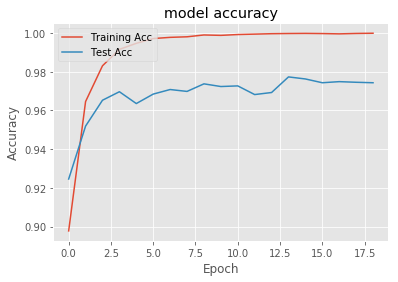

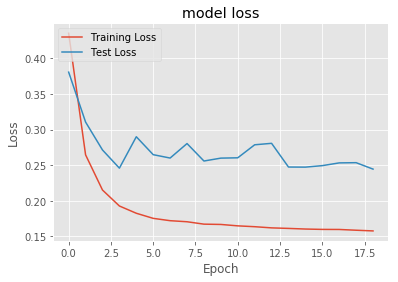

ValueError: x and y must have same first dimension, but have shapes (50,) and (19,)

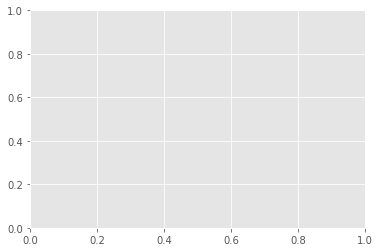

In [30]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [31]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.2519289430975914
Validation Accuracy:  0.9709375


In [32]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

11/10 [==============================] - 10s 878ms/step
No of errors = 15/697


Confusion Matrix
[[207   9]
 [  6 475]]


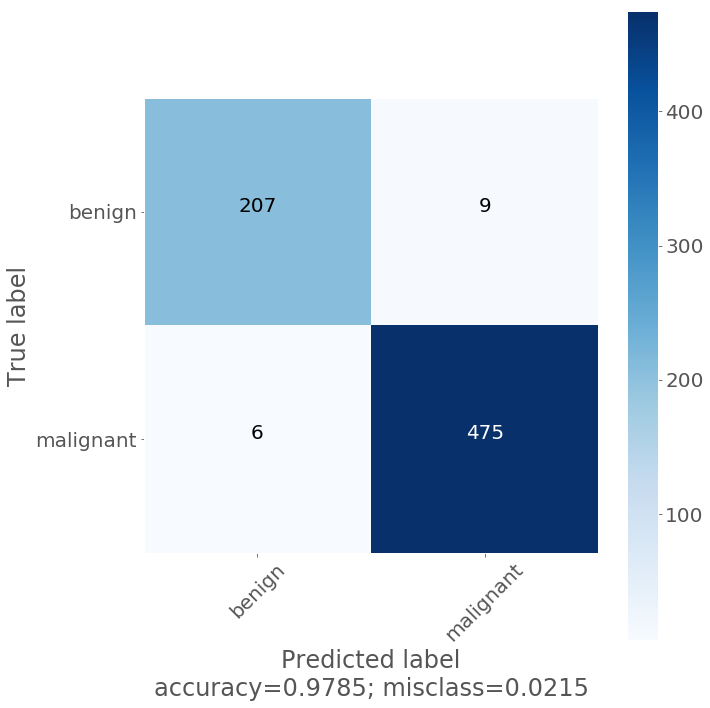

In [33]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[207   9]
 [  6 475]]
              precision    recall  f1-score   support

      benign       0.97      0.96      0.97       216
   malignant       0.98      0.99      0.98       481

   micro avg       0.98      0.98      0.98       697
   macro avg       0.98      0.97      0.97       697
weighted avg       0.98      0.98      0.98       697



In [35]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  97.84791965566714
Sensitivity :  97.1830985915493
Specificity :  98.14049586776859


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  97.8479
Precision: 98.1405
Recall:    98.7526
F1:        98.4456


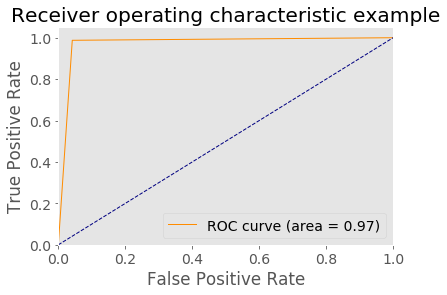

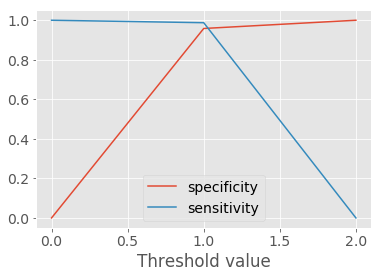

In [38]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [37]:
model.save('models/05.VGG19-BreaKHis-Model.h5')
model.save_weights('models/05.VGG19-BreaKHis-Weights.h5')

___

In [39]:
adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=True)
model.compile(optimizer= adam_opt2, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [40]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

with open('models/vgg19_history2.txt','w') as f:
    f.write(str(history.history))

Epoch 1/50
1611/1611 [==============================] - 1218s 756ms/step - loss: 0.3280 - acc: 0.9236 - val_loss: 0.4608 - val_acc: 0.8753
Epoch 2/50
1611/1611 [==============================] - 1217s 755ms/step - loss: 0.1722 - acc: 0.9786 - val_loss: 0.2940 - val_acc: 0.9242
Epoch 3/50
1611/1611 [==============================] - 1212s 753ms/step - loss: 0.1314 - acc: 0.9923 - val_loss: 0.1484 - val_acc: 0.9845
Epoch 4/50
1611/1611 [==============================] - 1225s 760ms/step - loss: 0.1140 - acc: 0.9961 - val_loss: 0.1558 - val_acc: 0.9797
Epoch 5/50
1611/1611 [==============================] - 1233s 766ms/step - loss: 0.1059 - acc: 0.9974 - val_loss: 0.1540 - val_acc: 0.9806
Epoch 6/50
1611/1611 [==============================] - 1227s 762ms/step - loss: 0.0965 - acc: 0.9990 - val_loss: 0.1972 - val_acc: 0.9706
Epoch 7/50
1611/1611 [==============================] - 1221s 758ms/step - loss: 0.0941 - acc: 0.9984 - val_loss: 0.1344 - val_acc: 0.9859
Epoch 8/50
1611/1611 [=====

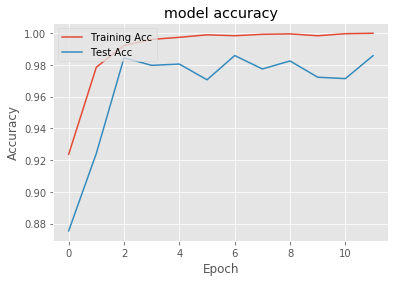

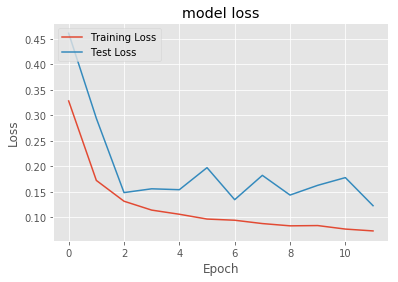

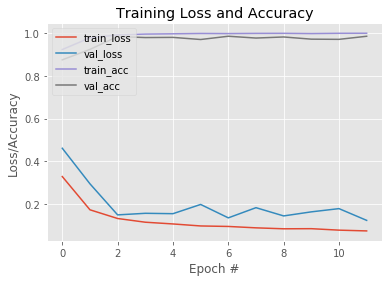

In [43]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = 12
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [44]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.13481663838028907
Validation Accuracy:  0.981875


In [45]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

11/10 [==============================] - 9s 790ms/step
No of errors = 9/697


Confusion Matrix
[[210   6]
 [  3 478]]


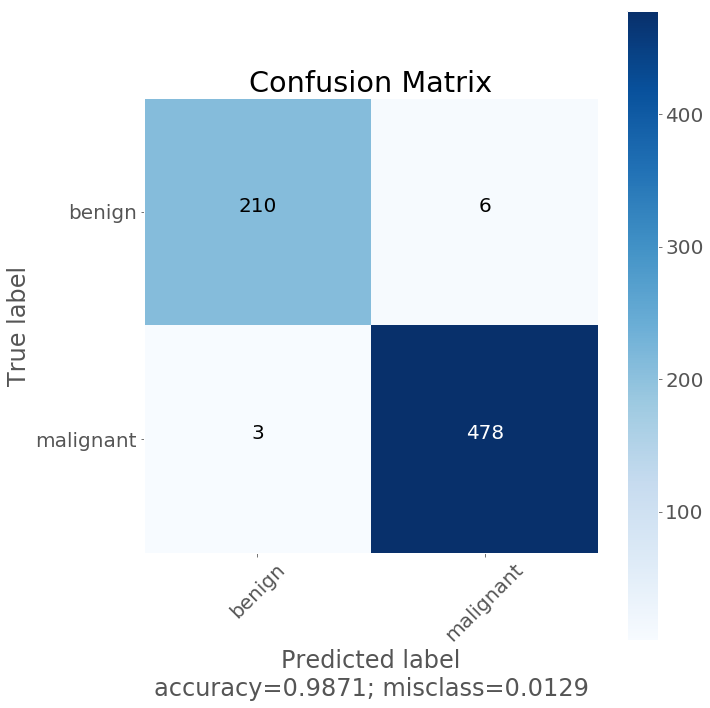

In [46]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))

plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[210   6]
 [  3 478]]
              precision    recall  f1-score   support

      benign       0.99      0.97      0.98       216
   malignant       0.99      0.99      0.99       481

   micro avg       0.99      0.99      0.99       697
   macro avg       0.99      0.98      0.98       697
weighted avg       0.99      0.99      0.99       697



In [50]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  98.70875179340028
Sensitivity :  98.59154929577466
Specificity :  98.7603305785124


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  98.7088
Precision: 98.7603
Recall:    99.3763
F1:        99.0674


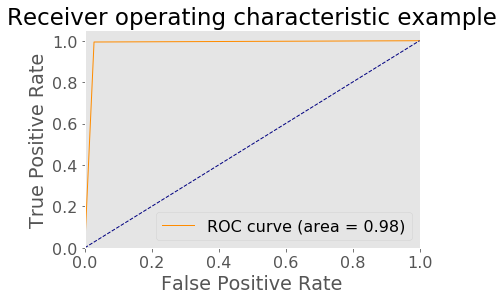

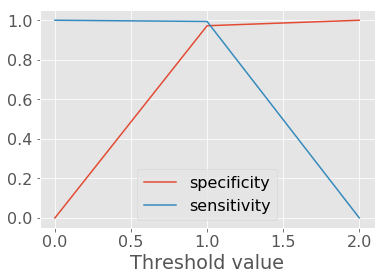

In [48]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [51]:
model.save('models/05.VGG19-2-BreaKHis-Model.h5')
model.save_weights('models/05.VGG19-2-BreaKHis-Weights.h5')